In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import cv2

from scipy.signal import find_peaks
import matplotlib
%matplotlib inline

ModuleNotFoundError: No module named 'scipy'

In [5]:
base_data_path = Path("/Volumes/data2/VAS/newflytrackerdata/20240213_muscle_recording")

muscle_data_path = base_data_path / "output_20240213_MHC_Gcamp6fhomo_fly000_trial001_postcalibration"
kinematics_data_path = base_data_path / "20240213/MHC_Gcamp6fhomo_fly000_trial001_postcalibration"

assert muscle_data_path.exists()
assert kinematics_data_path.exists()

In [6]:
# get the biggest file probably the brigghtest and with the most interesting muscle activity
n_files = 100 # number of files to check
muscle_files = sorted(muscle_data_path.glob("*.tif"), key=lambda x: x.stat().st_size)[-n_files:]

In [7]:
biggest_muscle_file = muscle_files[-1]
muscle_img = cv2.imread(str(biggest_muscle_file), cv2.IMREAD_GRAYSCALE)

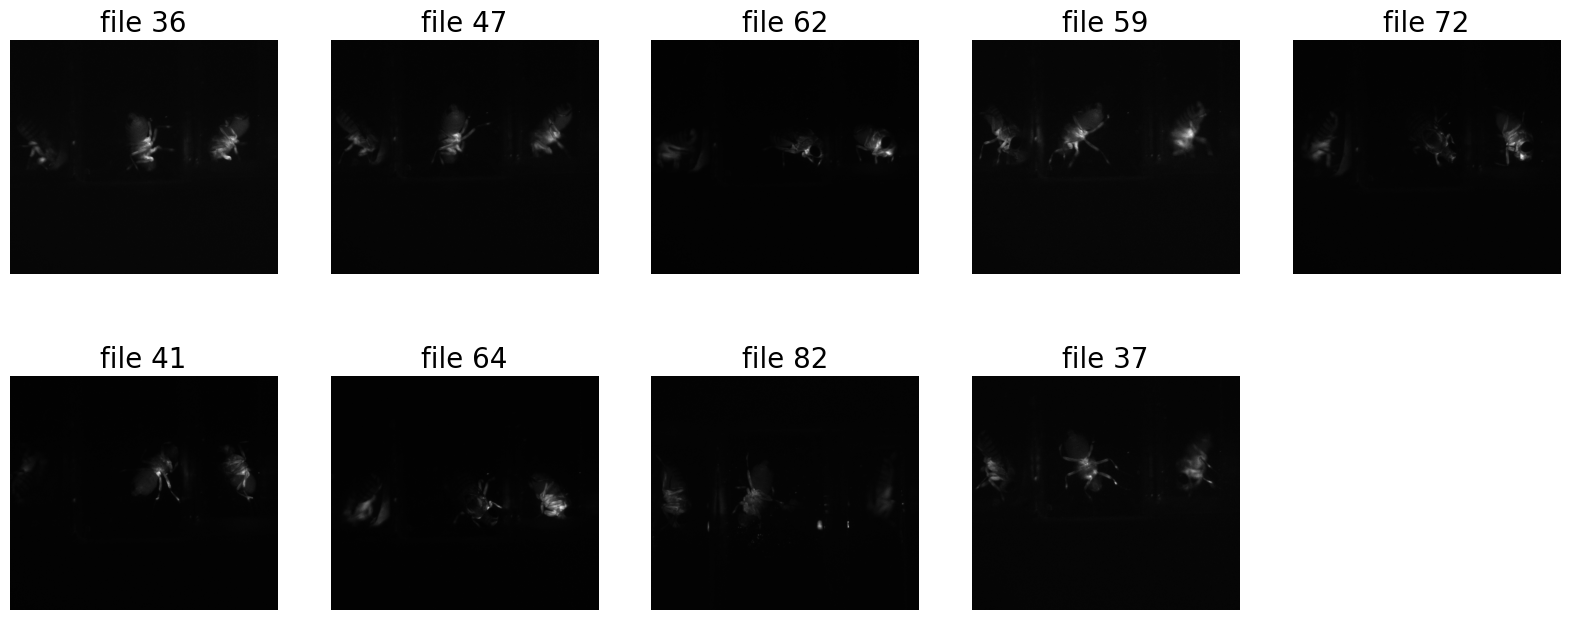

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.ravel()

# take 9 random files and plot them
muscle_ids = np.random.choice(len(muscle_files), 9)

for i, idx in enumerate(muscle_ids):
    muscle_img = cv2.imread(str(muscle_files[idx]), -1) # -1 means read as is, no conversion to 8 bit so the file is 16 bits
    axs[i].imshow(muscle_img*50.0, cmap="gray") # apply some gain to the image
    axs[i].set_title(f"file {idx}", fontsize=20)
for ax in axs:
    ax.axis("off")
plt.show()

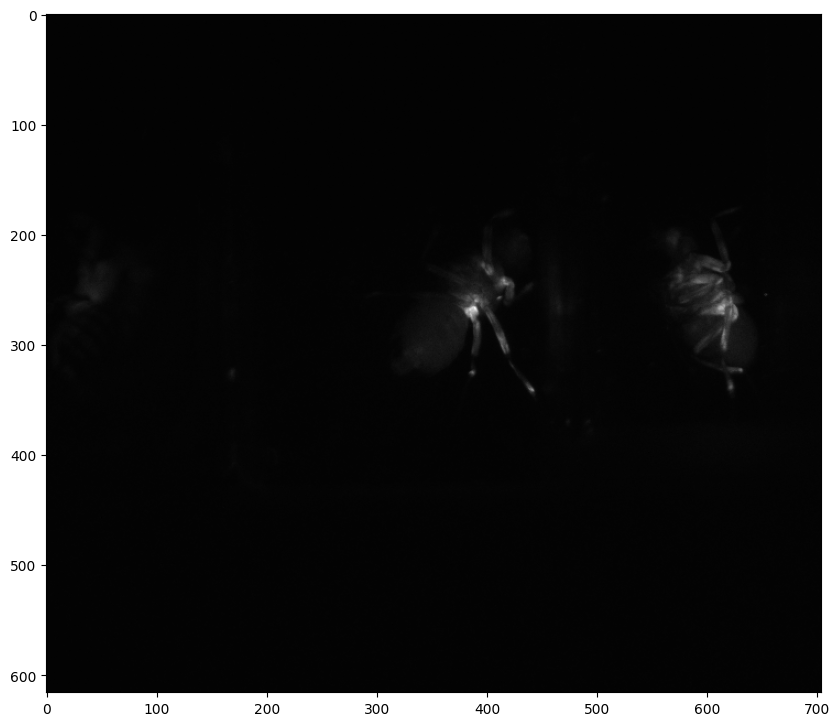

In [9]:
selected_muscle_file = muscle_files[79]
muscle_img = cv2.imread(str(selected_muscle_file), -1) # -1 means read as is, no conversion to 8 bit so the file is 16 bits
fig = plt.figure(figsize=(10, 10))
plt.imshow(muscle_img*50.0, cmap="gray") # apply some gain to the image
        

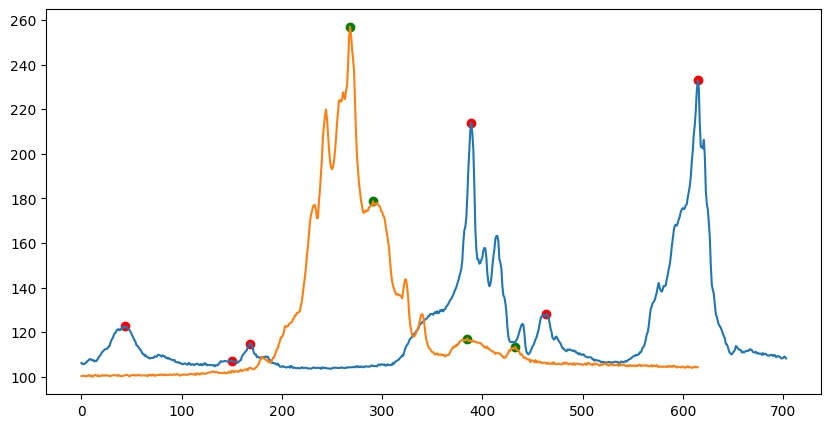

(-0.5, 224.5, 282.5, -0.5)

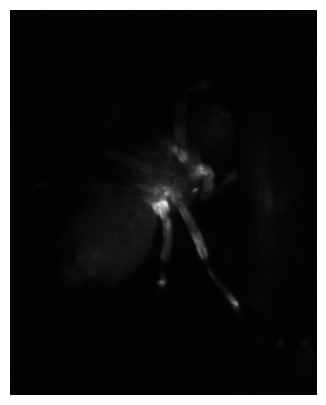

In [10]:
margin = 100

# we do not see much lets try to crop sharpen and normalize the image just for fun
mean_x = np.mean(muscle_img, axis=0)
mean_y = np.mean(muscle_img, axis=1)

# Get the max peak and crop around it
x_peaks, x_peaks_descr = find_peaks(mean_x, width=10, prominence = 0.9)
y_peaks, y_peaks_descr = find_peaks(mean_y, width=10, prominence = 0.9)

# get the width of the peak
x_width = x_peaks_descr["widths"]
y_width = y_peaks_descr["widths"]

plt.figure(figsize=(10, 5))
plt.plot(mean_x, label="mean x")
plt.plot(mean_y, label="mean y")
plt.scatter(x_peaks, mean_x[x_peaks], c="r", label="x peaks")
plt.scatter(y_peaks, mean_y[y_peaks], c="g", label="y peaks")
plt.show()

# get the max peak
max_y_peak = np.argmax(y_peaks_descr["prominences"])
# Get the most central peak
max_x_peak = np.argmin(np.abs(x_peaks- mean_x.shape[0]/2))

# get the start and end of the peak
x_start = int(x_peaks[max_x_peak] - x_width[max_x_peak]) - margin
x_end = int(x_peaks[max_x_peak] + x_width[max_x_peak]) + margin

y_start = int(y_peaks[max_y_peak] - y_width[max_y_peak]) - margin
y_end = int(y_peaks[max_y_peak] + y_width[max_y_peak]) + margin

# crop the image
cropped_img = muscle_img[y_start:y_end, x_start:x_end]
plt.figure(figsize=(5, 5))
plt.imshow(cropped_img*50.0, cmap="gray")
plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.2426547599768467


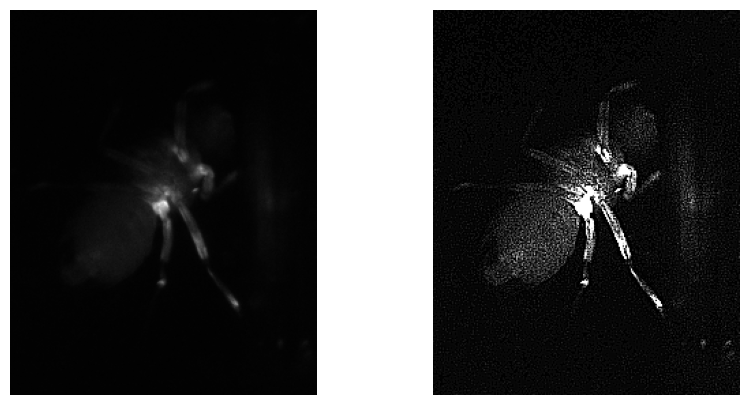

In [11]:
# apply gain to the image
# convert img to HSV
unit8_cropped_img = (cropped_img/np.max(cropped_img)*255).astype(np.uint8)
bgr = cv2.cvtColor(unit8_cropped_img, cv2.COLOR_GRAY2BGR)
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
hue, sat, val = cv2.split(hsv)

# compute gamma = log(mid*255)/log(mean)
mid = 0.08
mean = np.mean(val)
gamma = np.log(mid*255)/np.log(mean)
print(gamma)

# do gamma correction on value channel
val_gamma = np.power(val, gamma).clip(0,255).astype(np.uint8)

# combine new value channel with original hue and sat channels
hsv_gamma = cv2.merge([hue, sat, val_gamma])
img_gamma2 = cv2.cvtColor(hsv_gamma, cv2.COLOR_HSV2BGR)

# normalize the image
normalized_img = cv2.normalize(img_gamma2, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
# sharpen the image
sharpen_kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpened_img = cv2.filter2D(normalized_img, -1, sharpen_kernel)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cropped_img*50.0, cmap="gray")
axs[1].imshow(sharpened_img, cmap="gray")
for ax in axs:
    ax.axis("off")

In [12]:
# Not great maybe we should get another image or collect better data but anyways lets continue

# Get the corresponding kinematic image

In [13]:
selected_muscle_file

PosixPath('/Volumes/data2/VAS/newflytrackerdata/20240213_muscle_recording/output_20240213_MHC_Gcamp6fhomo_fly000_trial001_postcalibration/006685.tif')

In [14]:
# This is the fastest way but not the most readable
min_id_muscle_file = None
min_id_kin_file = None
i = 0
while (min_id_muscle_file is None or min_id_kin_file is None )and i < 1000:
    muscle_file = muscle_data_path / f"{i:06d}.tif"
    kin_file = kinematics_data_path / f"{i}.jpg"
    if muscle_file.exists() and min_id_muscle_file is None:
        min_id_muscle_file = i
    if kin_file.exists() and min_id_kin_file is None:
        min_id_kin_file = i
    i += 1

min_id_kin_file, min_id_muscle_file

(1, 0)

In [15]:
import yaml
# Load the camera calibration paths
with open(Path("./../calibration/config/calib_config.yaml"), 'r') as f:
    config = yaml.safe_load(f)
kin_to_muscle_div_factor = config["kin_to_muscle_div_factor"]

(-0.5, 1983.5, 1023.5, -0.5)

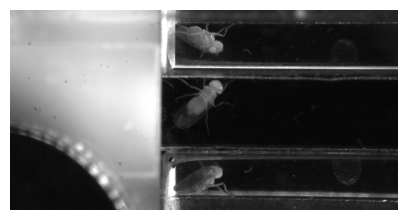

In [16]:
muscle_file_id = int(selected_muscle_file.stem)
matching_kin_frame_id = (muscle_file_id-min_id_muscle_file)*kin_to_muscle_div_factor + min_id_kin_file
# Now frames are saved in jpg images (every image contains 3 frames in each of the channels)
matching_kin_frame_channel = matching_kin_frame_id % 3 - min_id_kin_file%3
matching_kin_image_id = matching_kin_frame_id - matching_kin_frame_channel

kin_img = cv2.imread(str(kinematics_data_path / f"{matching_kin_image_id}.jpg"))[:, :, matching_kin_frame_channel] # No need for -1 as the image is 8 bits

fig = plt.figure(figsize=(5, 5))
plt.imshow(kin_img, cmap="gray")
plt.axis("off")

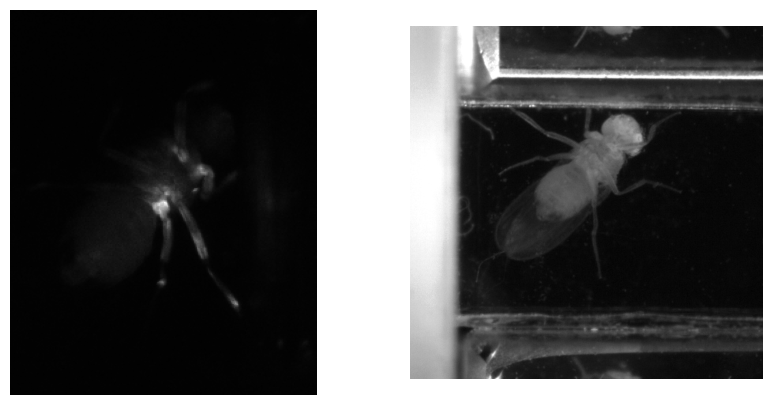

In [17]:
# crop and show side by side with the muscle
# Here for simplicity lets consider that the fly is always in the center of the image as a result of accurate tracking 

# crop the image
kin_image_shape = kin_img.shape
kin_crop_margin = 300
kin_image_centers = (kin_image_shape[1]//2, kin_image_shape[0]//2)
cropped_kin_image = kin_img[kin_image_centers[1] - kin_crop_margin:kin_image_centers[1] + kin_crop_margin,
                             kin_image_centers[0] - kin_crop_margin:kin_image_centers[0] + kin_crop_margin]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cropped_img*50.0, cmap="gray")
axs[1].imshow(cropped_kin_image, cmap="gray")
for ax in axs:
    ax.axis("off")
    
# Note the flip in the muscle image as the muscle camera is looking at a mirror

In [38]:
matplotlib.use('TkAgg') # to be able to use ginput

plt.figure(figsize=(20, 20))
plt.imshow(kin_img, cmap="gray")
plt.axis("off")

kin_femur_pts = plt.ginput(2, timeout=10) #number of clicks
kin_femur_pts = np.array(kin_femur_pts).copy()

In [39]:
kin_femur_pts

array([[925.63756614, 396.02910053],
       [988.28306878, 421.42592593]])

In [40]:
# Use inline backend for plotting
%matplotlib inline

In [41]:
from map_muscles.calibration.calibration_utils import draw_corresp_points, map_points

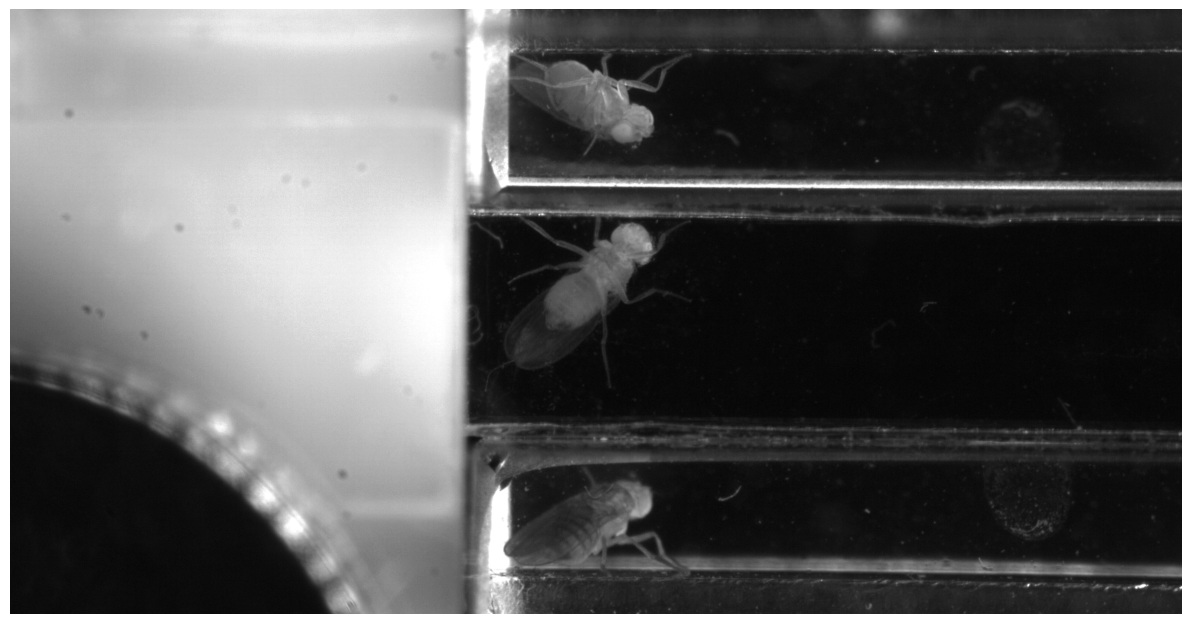

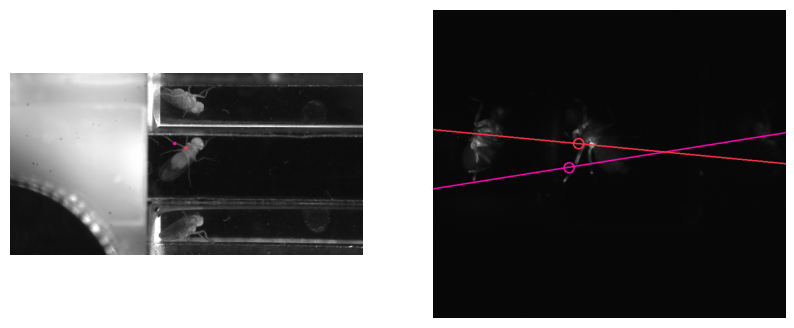

In [42]:
kin_femur_pts = np.array(kin_femur_pts).astype(int)

unit8_muscle_img = (muscle_img/np.max(muscle_img)*255).astype(np.uint8)
flipped_muscle_img = cv2.flip(unit8_muscle_img, 1)
kin_img_pts, muscle_img_wpts = draw_corresp_points(np.array(kin_femur_pts).round().astype(int), kin_img, flipped_muscle_img)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(kin_img_pts, cmap="gray")
axs[1].imshow(muscle_img_wpts, cmap="gray")
for ax in axs:
    ax.axis("off")

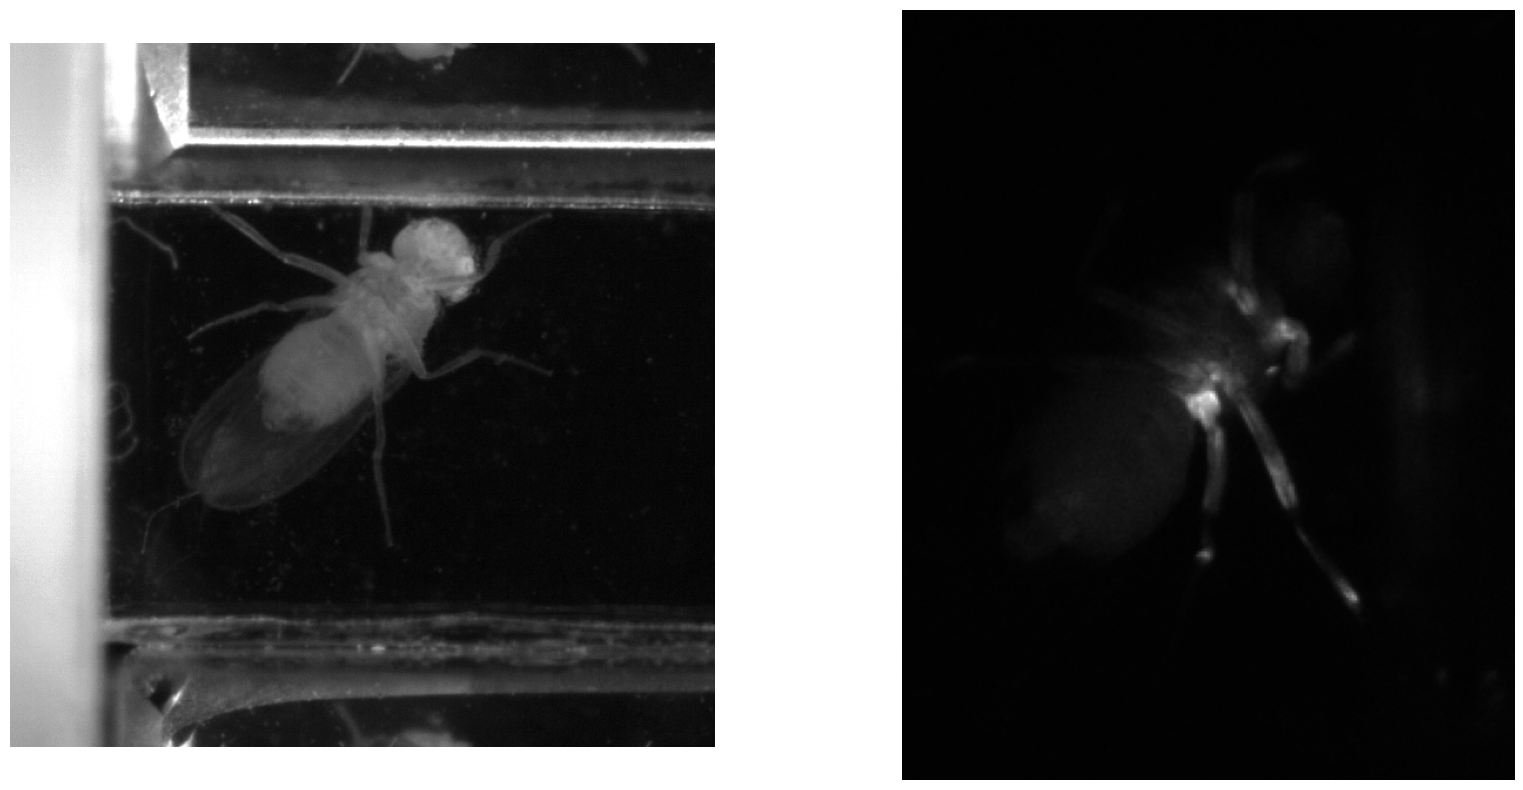

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(cropped_kin_image, cmap="gray")
axs[1].imshow(cropped_img*50.0, cmap="gray")
for ax in axs:
    ax.axis("off")

In [43]:
muscle_femur_pts = map_points(kin_femur_pts, muscle_img_shape=flipped_muscle_img.shape)

In [44]:
def get_rectangle(pts, half_width, margin):
    pts_vector = pts[1] - pts[0]
    pts_vector = pts_vector/np.linalg.norm(pts_vector)
    perp_pts_vector = np.array([-pts_vector[1], pts_vector[0]])
    perp_pts_vector = perp_pts_vector/np.linalg.norm(perp_pts_vector)

    rectangle_pts = np.array([pts[0] - pts_vector*margin  - half_width*perp_pts_vector,
                                pts[0] - pts_vector*margin + half_width*perp_pts_vector,
                                pts[1] + pts_vector*margin + half_width*perp_pts_vector,
                                pts[1] + pts_vector*margin - half_width*perp_pts_vector]).astype(int)
    return rectangle_pts

def draw_rectangle(pts, img, rectangle_half_width=50, margin=0):
    rectangle_pts = get_rectangle(pts, rectangle_half_width, margin)
    img_rect = cv2.polylines(img.copy(), [rectangle_pts], isClosed=True, color=(255, 255, 255), thickness=2)
    return img_rect

(-0.5, 1983.5, 1023.5, -0.5)

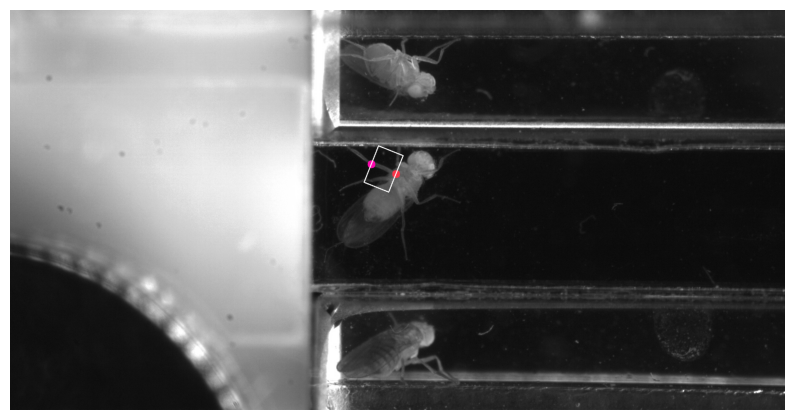

In [45]:
plt.figure(figsize=(10, 10))
plt.imshow(draw_rectangle(kin_femur_pts, kin_img_pts), cmap="gray")
plt.axis("off")

(-0.5, 703.5, 615.5, -0.5)

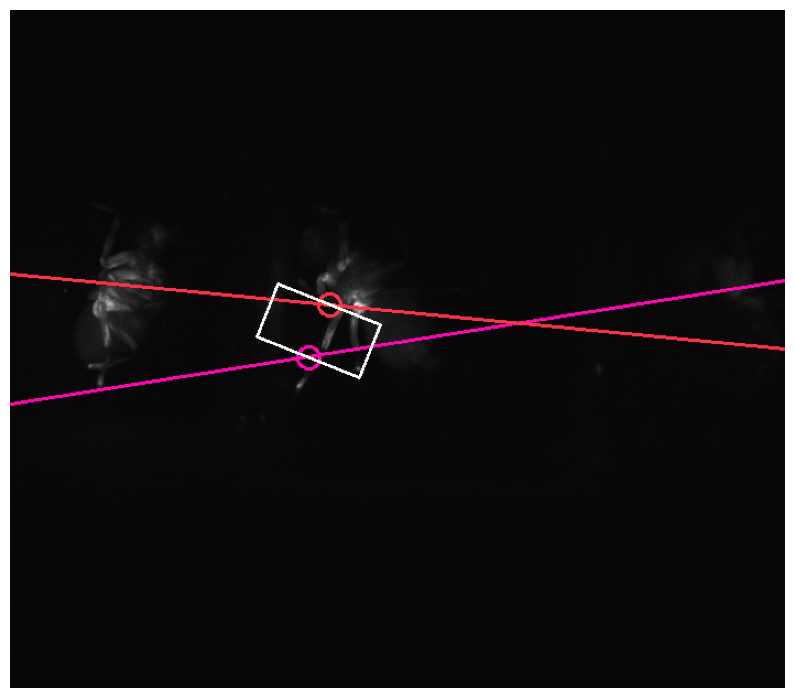

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(draw_rectangle(muscle_femur_pts, muscle_img_wpts), cmap="gray")
plt.axis("off")

In [47]:
def get_cropped_rectangle(img, rect_pts):
    # Set width and height of output image
    W = np.linalg.norm(rect_pts[1] - rect_pts[0]).round().astype(int)
    H = np.linalg.norm(rect_pts[2] - rect_pts[1]).round().astype(int)

    # Define points in input image: top-left, top-right, bottom-right, bottom-left
    pts0 = rect_pts.astype(np.float32)

    # Define corresponding points in output image
    pts1 = np.float32([[0,0],[W,0],[W,H],[0,H]])

    # Get perspective transform and apply it
    M = cv2.getPerspectiveTransform(pts0, pts1)
    result = cv2.warpPerspective(img, M, (W,H))
    return result

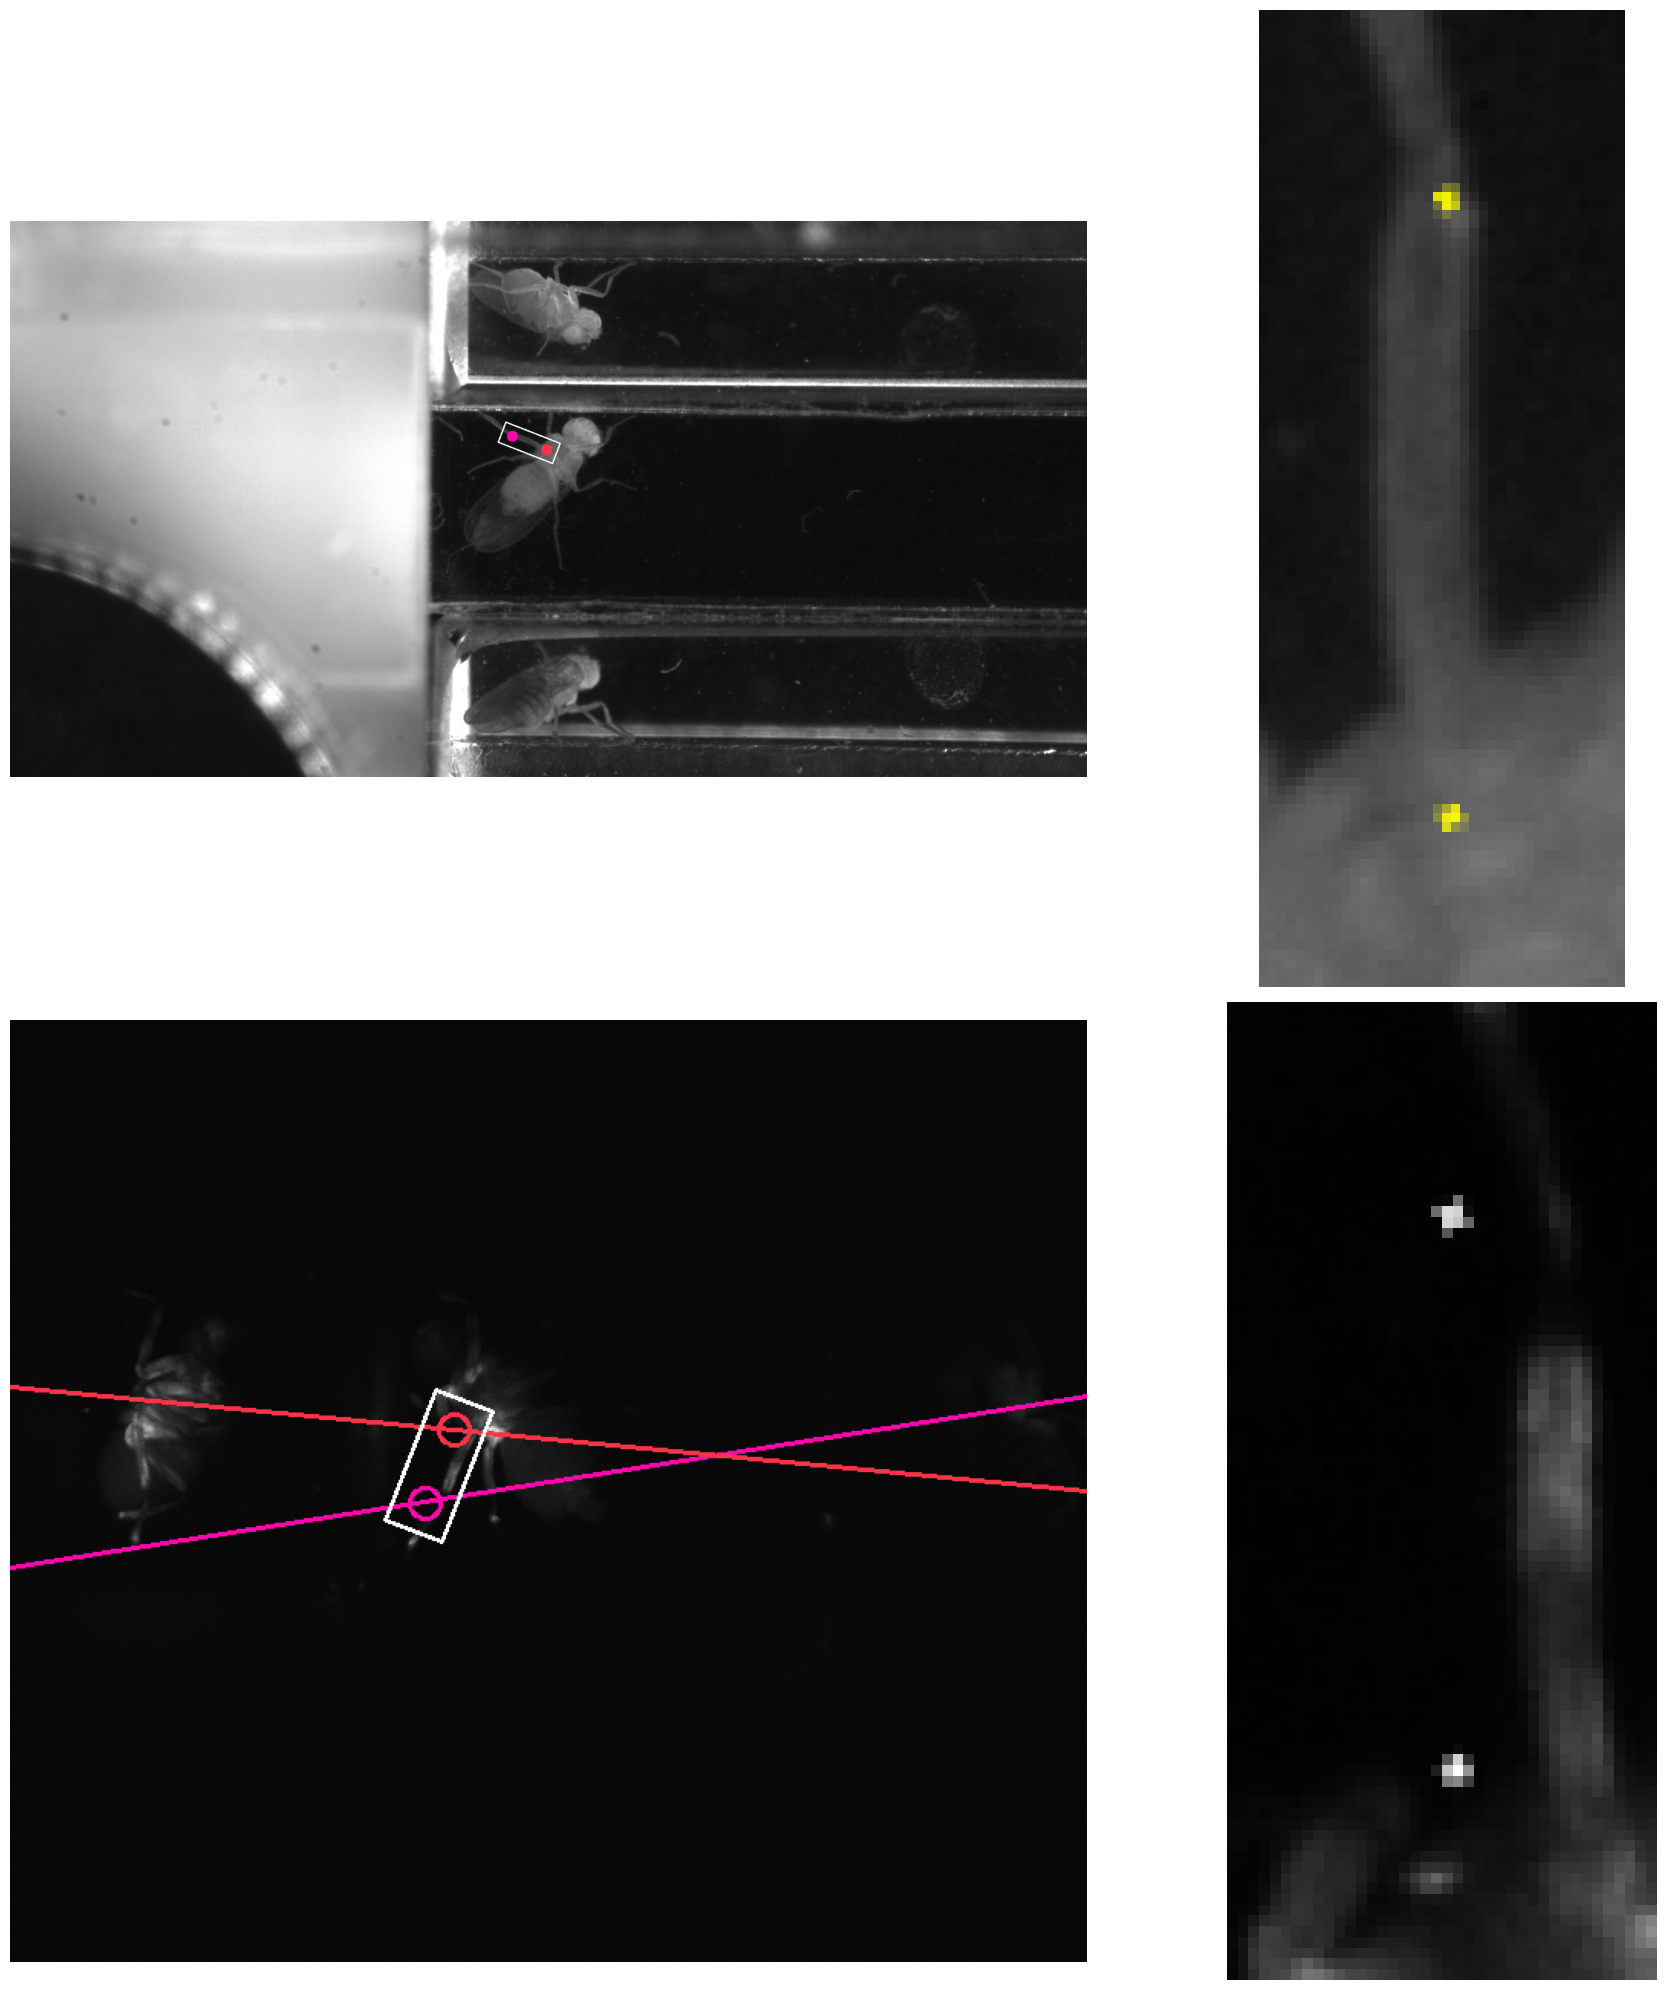

In [60]:
rectangle_half_width = 20
margin = 20

bgr_kin_img = cv2.cvtColor(kin_img, cv2.COLOR_GRAY2BGR)
for pts in kin_femur_pts:
    kin_img_wsmalldots = cv2.circle(bgr_kin_img, tuple(pts), 1, (255, 255, 0), -1)
for pts in muscle_femur_pts:
    muscle_img_wsmalldots = cv2.circle(flipped_muscle_img, tuple(pts), 1, (255, 255, 0), -1)


kin_rect_pts = get_rectangle(kin_femur_pts, rectangle_half_width, margin)
muscle_rect_pts = get_rectangle(muscle_femur_pts, rectangle_half_width, margin)

cropped_feature_kin_img = get_cropped_rectangle(kin_img_wsmalldots, kin_rect_pts)
cropped_feature_muscle_img = get_cropped_rectangle(muscle_img_wsmalldots, muscle_rect_pts)

muscle_img_w_rect = draw_rectangle(muscle_femur_pts, muscle_img_wpts, rectangle_half_width, margin)
kin_img_w_rect = draw_rectangle(kin_femur_pts, kin_img_pts, rectangle_half_width, margin)

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs = axs.ravel()
axs[0].imshow(kin_img_w_rect, cmap="gray")
axs[1].imshow(cropped_feature_kin_img, cmap="gray")
axs[2].imshow(muscle_img_w_rect, cmap="gray")
axs[3].imshow(cropped_feature_muscle_img, cmap="gray")
for ax in axs:
    ax.axis("off")
plt.tight_layout()

In [35]:
kin_img.shape

(1024, 1984)